In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal        # For Signal Processing functions, signal.welch, signal.firwin, signal.freqz and signal.lfilter
                                # https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html
from mpltools import layout
                            # http://tonysyu.github.io/mpltools/auto_examples/layouta/plot_cross_spines.html
from scipy.misc import derivative
import pyhrv                  #for time domain and signal domain features

%matplotlib inline

In [2]:
df = pd.read_excel(r'ecg-ex.xlsx', header=None, engine="openpyxl") # Read in excel file to dataframe in Pandas
ecg_data=df[0].to_numpy() # convert the single column of values to a numpy array
Fs = 250

In [3]:
f, ecg_welchperiodogram =  signal.welch(ecg_data, Fs, 'boxcar', nperseg=1024, detrend=False) 

signal.welch is a scipy function to calculate the spectrum of a signal using the Welch Method.
see  https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#spectral-analysis-using-welch-s-method

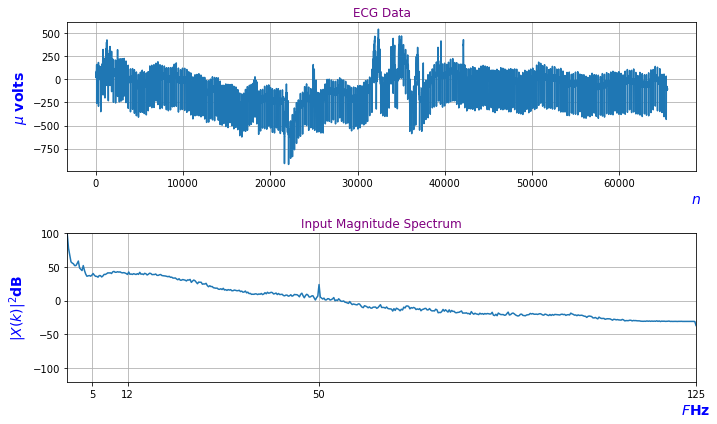

In [4]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(ecg_data
        )
plt.title("ECG Data", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.grid(True)
plt.subplot(212)
plt.plot(f, 20*np.log10(ecg_welchperiodogram))
plt.title("Input Magnitude Spectrum", color ="purple")
plt.ylabel('$|X(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.xticks([5,12,50,125])
plt.axis([0,125,-120,100])
plt.grid(True)
plt.tight_layout() # ensure sufficient spacing between subplots


# High Pass Filter Design

In [5]:
Fc = 5  ##### Cutoff Frequency in Hz
deltaF = 1 #### Transition Bandwidth in Hz


In [6]:
M = int(np.ceil(5.5 * Fs/deltaF)) # Filter Length  ******Check Odd******

1375

In [7]:
MidM = int((M-1)/2) #Filter Midpoint

In [8]:
ncoeffHP = signal.firwin(M, Fc, window = 'hann', fs = Fs, pass_zero=False) 
# firwin is a scipy function to design an FIR filter using the Windows method. 
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html#scipy.signal.firwin 


In [9]:
w, HWHP = signal.freqz(ncoeffHP, fs = Fs)
# freqz is a scipy function to calculate the frequency response of a filter. 
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html#scipy.signal.freqz

 Plotting Impulse  & Frequency Response

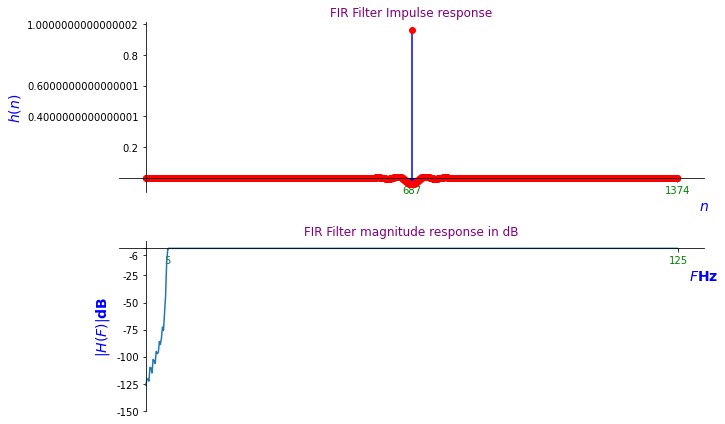

In [10]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.stem(ncoeffHP, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
plt.title("FIR Filter Impulse response", color ="purple")
plt.ylabel('$h(n)$', fontsize=14, color="blue", weight="bold") # Could use rotation=0
plt.xlabel('$n$', fontsize=14, color="blue",  x=1.0)
layout.cross_spines(zero_cross=True)
plt.xticks([0,MidM,M-1], color="green")
plt.subplot(212)
plt.plot(w,20*np.log10(np.abs(HWHP)))
plt.title("FIR Filter magnitude response in dB", color ="purple")
plt.ylabel('$|H(F)|$dB', fontsize=14, color="blue", weight="bold") 
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
layout.cross_spines(zero_cross=True)
plt.yticks([-150,-125,-100,-75,-50,-25,-6,0])
plt.xticks([5,125], color="green")
plt.tight_layout() # ensure sufficient spacing between subplots

In [11]:
ecg_HPoutput = signal.lfilter(ncoeffHP, [1.0], ecg_data)

signal.lfilter is a scipy function to implement the filter.  Note that lfilter works for both IIR and FIR.
Thus [1.0] required as an FIR not IIR filter.
See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter

In [12]:
f, ecg_HPoutputwelch =  signal.welch(ecg_HPoutput, Fs, 'boxcar', nperseg=1024, detrend=False) 

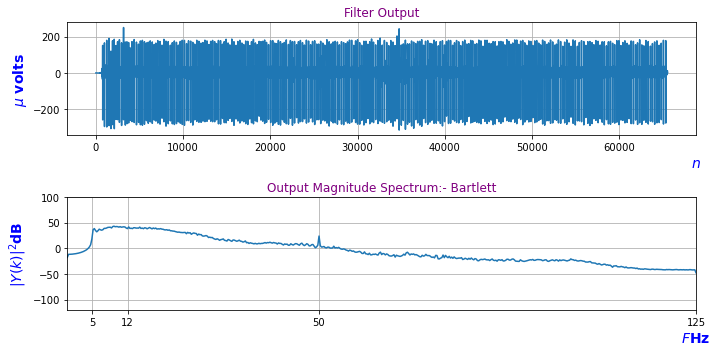

In [13]:
plt.figure(figsize = (10,5)) # 10 in by 6 in
plt.subplot(211)
plt.plot(ecg_HPoutput)
plt.title("Filter Output", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.grid(True)
plt.subplot(212)
plt.plot(f, 20*np.log10(ecg_HPoutputwelch))
plt.title("Output Magnitude Spectrum:- Bartlett", color ="purple")
plt.ylabel('$|Y(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.xticks([5,12,50,125])
plt.axis([0,125,-120,100])
plt.grid(True)
plt.tight_layout() # ensure sufficient spacing between subplots


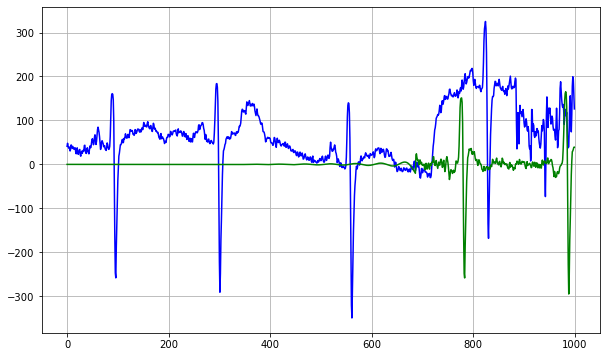

In [14]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.plot(ecg_data[0:1000], 'blue') # Original ECH
plt.plot(ecg_HPoutput[0:1000],'green') # Output of High Pass Filter
plt.grid(True)

In [15]:
ecg_HPoutputLR = ecg_HPoutput[MidM:len(ecg_HPoutput)] # Remove the first (M-1)/2 data points to remove the latency

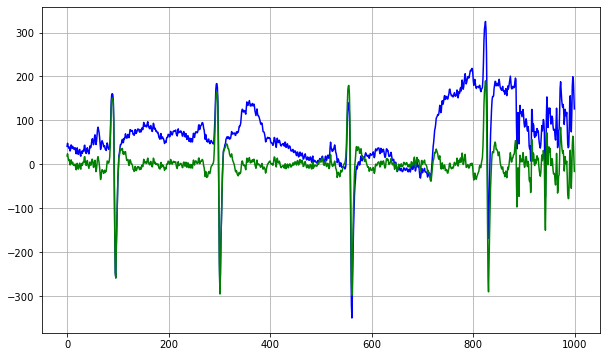

In [16]:
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.plot(ecg_data[0:1000], 'blue') # Original ECG
plt.plot(ecg_HPoutputLR[0:1000],'green') # Output of High Pass filter with Latency corrected. 
plt.grid(True)

# Lowpass Filter Design

In [17]:
deltaLPF = 6 #### Transition Bandwidth in Hz
LPPassbandF = 12  #### Passband Edge Frequency in Hz
FcLP = LPPassbandF + deltaLPF/2   ##### Cutoff Frequency in Hz ()

In [18]:
MLP = int(np.ceil(5.5 * Fs/deltaLPF)) # Filter Length  ******Check Odd****** Using hann Window
MLP

230

In [19]:
MLP = 231 # select M to be odd for Integer Group Delay
MidMLP = int((MLP-1)/2) #Filter Midpoint

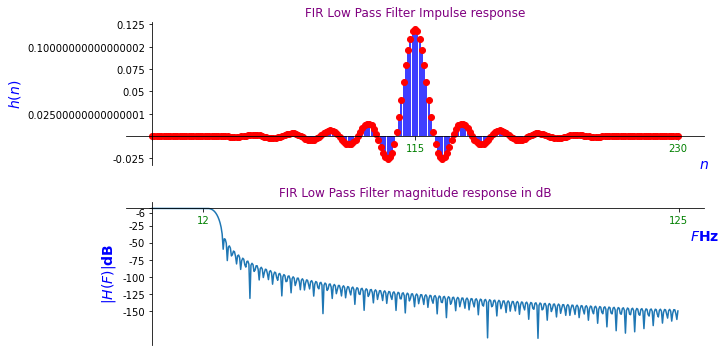

In [20]:
ncoeffLP = signal.firwin(MLP, FcLP, window = 'hann', fs = Fs, pass_zero=True) 
w, HWLP = signal.freqz(ncoeffLP, fs = Fs)
plt.figure(figsize = (10,5)) # 10 in by 5 in
plt.subplot(211)
plt.stem(ncoeffLP, linefmt='blue', markerfmt='ro', use_line_collection = True, basefmt=" ")
plt.title("FIR Low Pass Filter Impulse response", color ="purple")
plt.ylabel('$h(n)$', fontsize=14, color="blue", weight="bold") # Could use rotation=0
plt.xlabel('$n$', fontsize=14, color="blue",  x=1.0)
layout.cross_spines(zero_cross=True)
plt.xticks([0,MidMLP,MLP-1], color="green")
#plt.yticks([-0.01,0.048,0.05])
#plt.axis([0,M-1,-0.015,0.05])
plt.subplot(212)
plt.plot(w,20*np.log10(np.abs(HWLP)))
plt.title("FIR Low Pass Filter magnitude response in dB", color ="purple")
plt.ylabel('$|H(F)|$dB', fontsize=14, color="blue", weight="bold") 
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
layout.cross_spines(zero_cross=True)
plt.yticks([-150,-125,-100,-75,-50,-25,-6,0])
plt.xticks([12,125], color="green")
plt.tight_layout() # ensure sufficient spacing between subplots

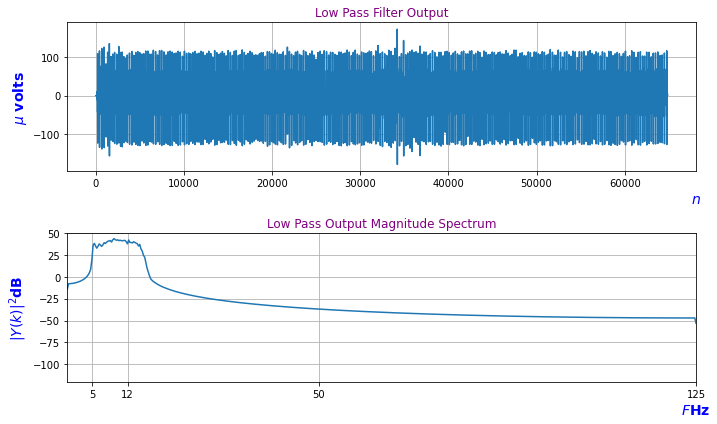

In [21]:
ecg_LPoutput = signal.lfilter(ncoeffLP, [1.0], ecg_HPoutputLR)
f, ecg_LPoutputwelch =  signal.welch(ecg_LPoutput, Fs, 'boxcar', nperseg=1024, detrend=False) 
plt.figure(figsize = (10,6)) # 10 in by 6 in
plt.subplot(211)
plt.plot(ecg_LPoutput)
plt.title("Low Pass Filter Output", color ="purple")
plt.ylabel('$\mu$ volts', fontsize=14, color="blue", weight="bold")
plt.xlabel('$n$', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.grid(True)
plt.subplot(212)
plt.plot(f, 20*np.log10(ecg_LPoutputwelch))
plt.title("Low Pass Output Magnitude Spectrum", color ="purple")
plt.ylabel('$|Y(k)|^2$dB', fontsize=14, color="blue", weight="bold")
plt.xlabel('$F$Hz', fontsize=14, color="blue", weight="bold",  x=1.0)
plt.xticks([5,12,50,125])
plt.axis([0, 125,-120,50])
plt.grid(True)
plt.tight_layout() # ensure sufficient spacing between subplots


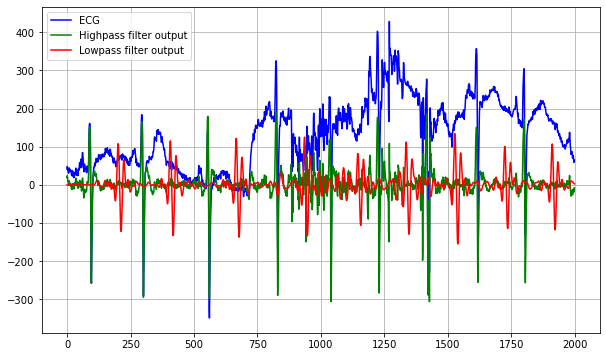

In [22]:
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:2000],'blue',label='ECG') # Original ECG
plt.plot(ecg_HPoutputLR[0:2000], 'green',label='Highpass filter output') #Output of High Pass FIlter
plt.plot(ecg_LPoutput[0:2000], 'red',label='Lowpass filter output') # Output of Low Pass Filter#
plt.legend(loc="upper left")
plt.grid(True)


In [23]:
ecg_LPoutputLR = ecg_LPoutput[MidMLP:len(ecg_LPoutput)] # Remove the first (M-1)/2 data points to remove the latency

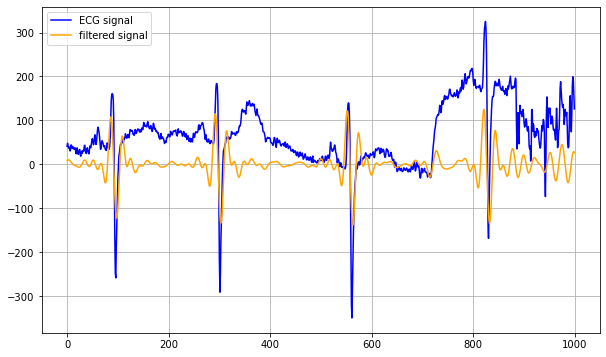

In [24]:
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:1000], 'blue',label='ECG signal') # Original ECG
plt.plot(ecg_LPoutputLR[0:1000], 'orange',label='filtered signal') # Output of Low Pass filter with Latency for both filters taken into account
plt.legend(loc="upper left")
plt.grid(True)

# Derivative

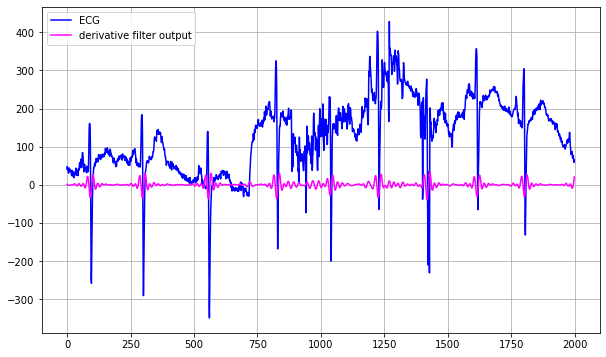

In [25]:
#get derivative from ECG signal  (using np library)
ecg_derivative=np.diff(ecg_LPoutputLR)           
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:2000],'blue',label='ECG') # Orginal ECG
plt.plot(ecg_derivative[0:2000], 'magenta',label='derivative filter output') # Output of Derivative
plt.legend(loc="upper left")
plt.grid(True)

# Squared signal

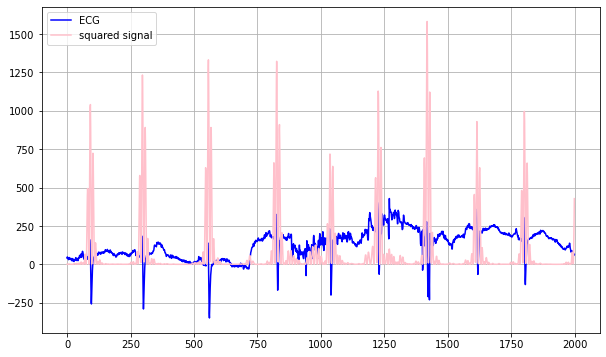

In [26]:
#signal is squared to enhance the dominant peaks (QRSs) and reduce the possibility of erroneously recognizing a T wave as an R peak
ecg_squared=ecg_derivative**2
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:2000],'blue',label='ECG') # Orginal ECG  
plt.plot(ecg_squared[0:2000], 'pink',label='squared signal') # Output of Squarer Aligned to take into account filter latencies
plt.legend(loc="upper left")
plt.grid(True)

In [27]:
0.14*Fs # 1s of data is 250 samples so 140ms is given by this

35.0

# applying moving average window

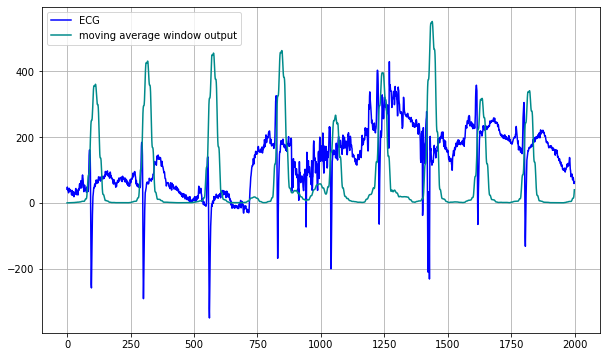

In [28]:
#implementing moving average window
N=int(0.14*Fs) # determine the number of sample based on a window of 140ms = 0.14s
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'full') / w

ecg_movingaverage=moving_average(ecg_squared,N)          #neonatal heart rate is 140ms
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:2000],'blue',label='ECG') # Orginal ECG  
plt.plot(ecg_movingaverage[0:2000], 'darkcyan',label='moving average window output') 
plt.legend(loc="upper left")
plt.grid(True)

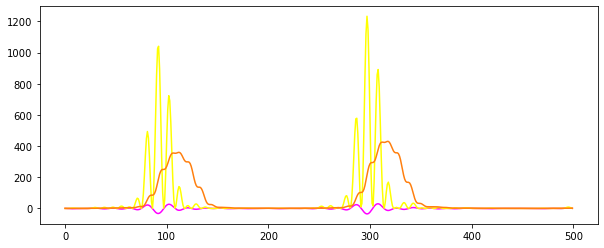

In [29]:
plt.figure(figsize = (10,4))
plt.plot(ecg_derivative[0:500], 'magenta') # Output of Derivative
plt.plot(ecg_squared[0:500], 'yellow') # Output of Squarer Aligned to take into account filter latencies
plt.plot(ecg_movingaverage[0:500], 'tab:orange') 

# Peak detection

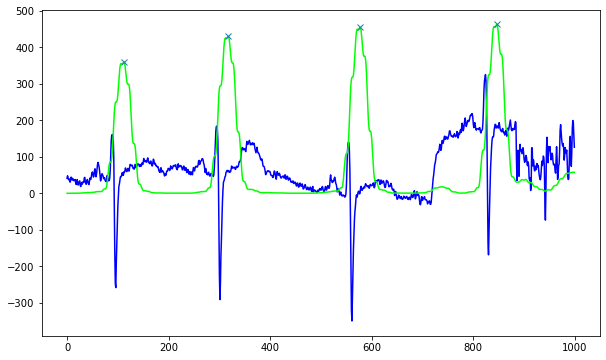

In [30]:
#detecting signal peaks(preprocessed)
from scipy.signal import find_peaks
peaks = find_peaks(ecg_movingaverage, threshold=None ,height=200, distance=35)[0]
plt.figure(figsize = (10,6))
plt.plot(ecg_data[0:1000],'blue') # Orginal ECG  
plt.plot(ecg_movingaverage[0:1000], 'lime') 
plt.plot(peaks[0:4],ecg_movingaverage[peaks][0:4],"x")

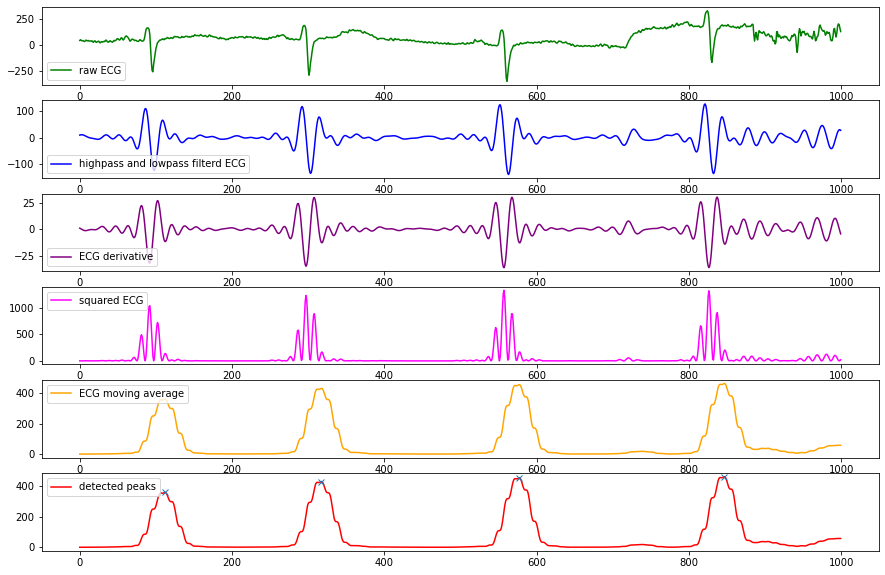

In [31]:
#whole process of peak detection
plt.figure(figsize = (15,10))
plt.subplot(6, 1, 1)
plt.plot(ecg_data[0:1000], 'green',label='raw ECG') 
plt.legend(loc="lower left")
plt.subplot(6, 1, 2)
plt.plot(ecg_LPoutputLR[0:1000], 'blue',label='highpass and lowpass filterd ECG') 
plt.legend(loc="lower left")
plt.subplot(6, 1, 3)
plt.plot(ecg_derivative[0:1000], 'purple', label='ECG derivative') 
plt.legend(loc="lower left")
plt.subplot(6, 1,4)
plt.plot(ecg_squared[0:1000], 'magenta', label='squared ECG') 
plt.legend(loc="upper left")
plt.subplot(6, 1, 5)
plt.plot(ecg_movingaverage[0:1000], 'orange', label='ECG moving average')
plt.legend(loc="upper left")
plt.subplot(6, 1, 6)
plt.plot(ecg_movingaverage[0:1000], 'red', label='detected peaks')
plt.plot(peaks[0:4],ecg_movingaverage[peaks][0:4],"x")
plt.legend(loc="upper left")

# rr-interval and Heart rate

In [32]:
#calculating rr-intervals and heart rate
rr = np.diff(peaks)
HR=60/(rr/Fs)

# interpolation

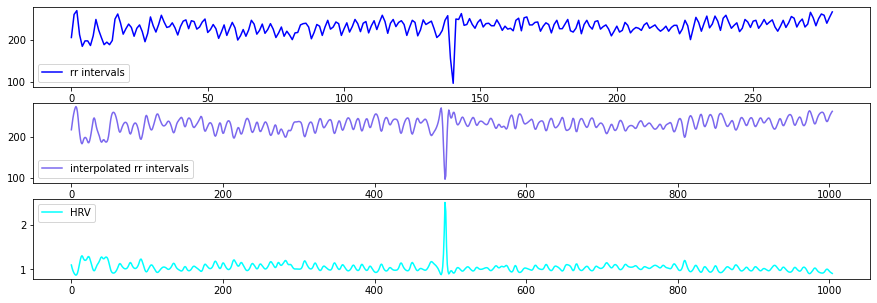

In [33]:
#signal interpolation(quadratic)
from scipy import interpolate
x_2 = np.cumsum(rr)/ 256
f = interpolate.interp1d(x_2, rr, kind='quadratic',fill_value="extrapolate")

# sample rate for interpolation
fs = 4
steps = 1 / fs

# now we can sample from interpolation function
xx_2 = np.arange(1, np.max(x_2), steps)

rr_interpolated = f(xx_2)
HR_new=60/(rr_interpolated/fs)

plt.figure(figsize = (15,5))
plt.subplot(3, 1, 1)
plt.plot(rr, 'blue',label='rr intervals') 
plt.legend(loc="lower left")
plt.subplot(3, 1, 2)
plt.plot(rr_interpolated, 'mediumslateblue', label='interpolated rr intervals') 
plt.legend(loc="lower left")
plt.subplot(3, 1, 3)
plt.plot(HR_new, 'aqua', label='HRV') 
plt.legend(loc="upper left")


In [34]:
print(rr_interpolated)

[218.57607425 233.68788021 246.65725972 ... 258.37144348 261.6280923
 264.2958073 ]


# Epoch setting

In [35]:
NEpoch = 4*60                                        # fs=4 (after interpolation), each epoch is 60 seconds                                  # Define spamles of each epoch
Noverlap = int(NEpoch/2)                                                  # Dinfine overlap of each epoch= 50%
numberofEpochs = (len(HR_new)-NEpoch)//(NEpoch-Noverlap) + 1       # Use integer divison // to get exact number of epochs
NEP=int(numberofEpochs) 
print('Number of Epochs:',numberofEpochs)

Number of Epochs: 7


# Time domain features

In [36]:
#Time domain features
epoch_start = 0
muNNarray = np.array([])
SDNNarray=np.array([])


for i in range(NEP):
    interval=HR_new[epoch_start:(epoch_start+NEpoch)]
    muNN=np.mean(interval)                          #mean NN interval (muNN)
    SDNN=pyhrv.time_domain.sdnn(interval)           #Standard deviation of a NNI series
    
    epoch_start += Noverlap
    muNNarray = np.append(muNNarray, muNN)
    SDNNarray= np.append(SDNNarray, SDNN)

    
    
print('muNN=',muNNarray,'SDNN=',SDNNarray, sep='\n')

muNN=
[1.06789841 1.06232561 1.04982732 1.03686235 1.0419892  1.04151019
 1.02468172]
SDNN=
[ 93.19760653  59.6457879   61.50113729 152.5066464  150.11766073
  46.81924574  49.26052744]


# Normalized time features

In [37]:
from sklearn import preprocessing
muNN_normalize=preprocessing.normalize([muNNarray],norm='max')
SDNN_normalize=preprocessing.normalize([SDNNarray],norm='max')

print('muNN=',muNN_normalize,'SDNN=',SDNN_normalize,sep='\n')

muNN=
[[1.         0.99478153 0.9830779  0.97093725 0.97573813 0.97528959
  0.95953109]]
SDNN=
[[0.61110521 0.39110288 0.40326857 1.         0.9843352  0.30699807
  0.32300577]]


# Geometrical features

In [38]:
epoch_start = 0
TINNarray=np.array([])

for i in range(NEP):
    interval=HR_new[epoch_start:(epoch_start+NEpoch)]
    TINN=pyhrv.time_domain.tinn(nni=interval,plot=False)
    tinn=TINN['tinn']
    
    epoch_start += Noverlap
    TINNarray=np.append(TINNarray,tinn)
    
print('TINN=',TINNarray, sep='\n')

C:\Users\KimiaR\Anaconda3\envs\pytorchenv\lib\site-packages\pyhrv\time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '


TINN=
[210.9375 226.5625 226.5625 171.875  218.75   171.875  179.6875]


# Normalized geometrical features

In [39]:
#normalized geometrical features
TINN_normalize=preprocessing.normalize([TINNarray],norm='max') 
print('TINN=',TINN_normalize, sep='\n')

TINN=
[[0.93103448 1.         1.         0.75862069 0.96551724 0.75862069
  0.79310345]]


# Frequency domain features

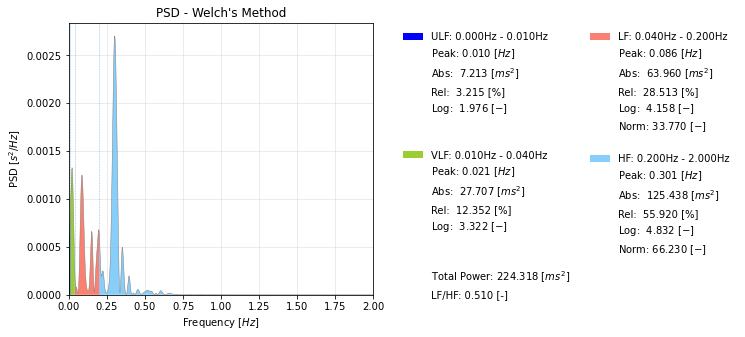

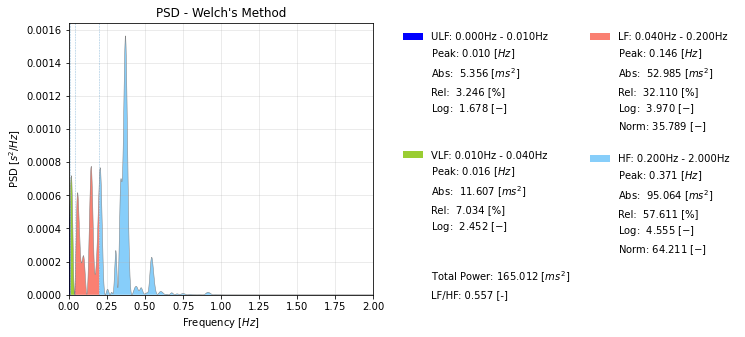

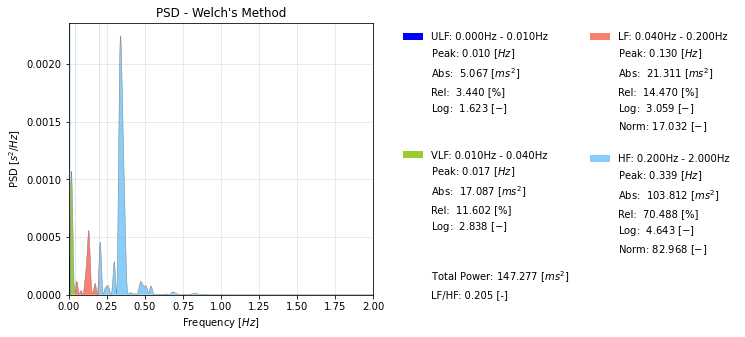

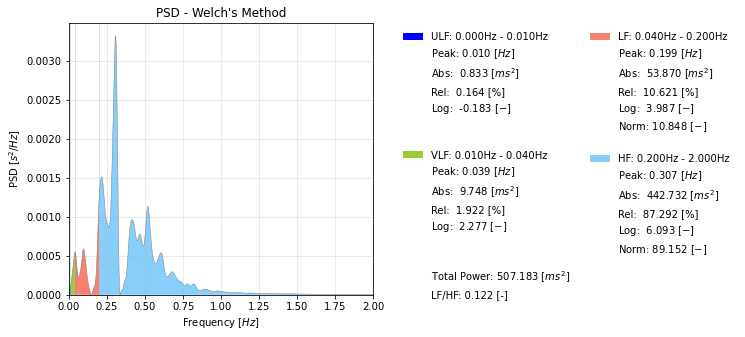

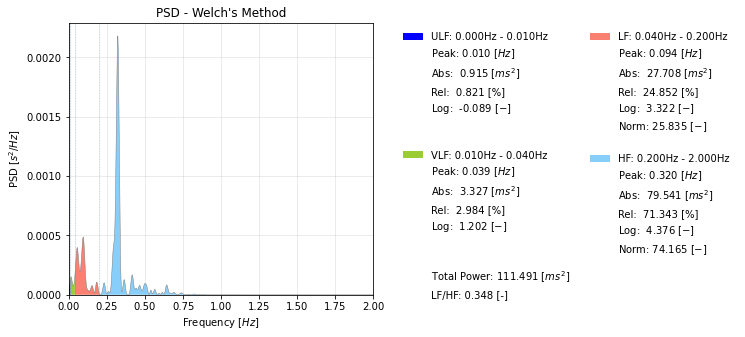

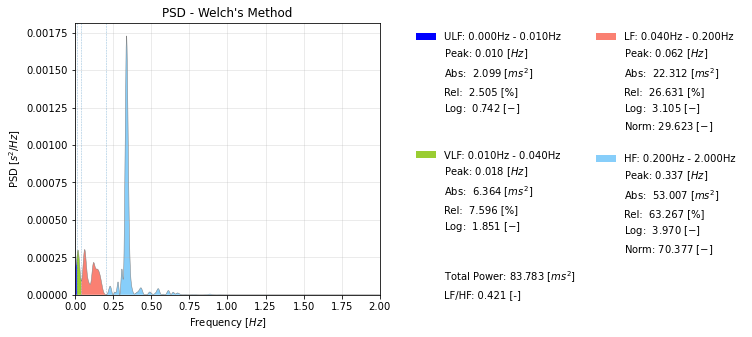

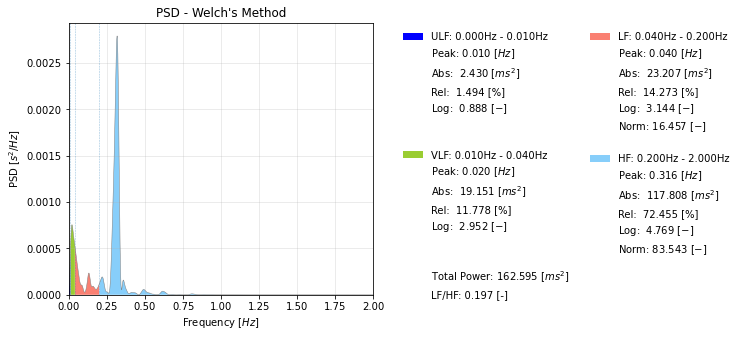

LF/HF ratio(welch): [0.50989564 0.55735544 0.20528704 0.12167676 0.34835103 0.42092611
 0.19699145] VLF power(welch): [ 1.97585618  1.6782443   1.62270121 -0.18299454 -0.08903249  0.74152384
  0.88780073] LF power(welch): [3.32168262 2.45159257 2.8383146  2.27709909 1.20195308 1.85070036
 2.95232909] HF power(welch): [4.15826059 3.97000112 3.05923865 3.98657696 3.32173107 3.10513108
 3.14445952]


In [40]:
#frequency domain features (welch method)
epoch_start = 0
fftratioarray=np.array([])
welch_Logarithmic_array_VLF=np.array([])
welch_Logarithmic_array_LF=np.array([])
welch_Logarithmic_array_HF=np.array([])

for i in range(NEP):
    fbands={'ulf': (0.0, 0.01),'vlf': (0.01, 0.04), 'lf': (0.04, 0.2), 'hf': (0.2, 2)}
    welch_freq_features=pyhrv.frequency_domain.welch_psd(rr_interpolated[epoch_start:(epoch_start+NEpoch)],fbands=fbands)
    epoch_start += Noverlap
    
    fftratioarray= np.append(fftratioarray, welch_freq_features['fft_ratio'])
    
    welch_Logarithmic_powers=welch_freq_features['fft_log']
    welch_Logarithmic_array_VLF= np.append(welch_Logarithmic_array_VLF, welch_Logarithmic_powers[0])
    welch_Logarithmic_array_LF= np.append(welch_Logarithmic_array_LF, welch_Logarithmic_powers[1])
    welch_Logarithmic_array_HF= np.append(welch_Logarithmic_array_HF, welch_Logarithmic_powers[2])

    
print('LF/HF ratio(welch):',fftratioarray,'VLF power(welch):',welch_Logarithmic_array_VLF,'LF power(welch):',welch_Logarithmic_array_LF,'HF power(welch):',welch_Logarithmic_array_HF)

# Normalized frequency features

In [41]:
#lomb and welch normalized frequancy features
fftratio_normalize=preprocessing.normalize([fftratioarray],norm='max') 
welch_VLF_normalize=preprocessing.normalize([welch_Logarithmic_array_VLF],norm='max') 
welch_LF_normalize=preprocessing.normalize([welch_Logarithmic_array_LF],norm='max') 
welch_HF_normalize=preprocessing.normalize([welch_Logarithmic_array_HF],norm='max') 

print('LF/HF ratio(welch):',fftratio_normalize,'VLF power(welch):',welch_VLF_normalize,'LF power(welch):',welch_LF_normalize,'HF power(welch):',welch_HF_normalize, sep='\n')

LF/HF ratio(welch):
[[0.91484824 1.         0.36832338 0.21831088 0.62500695 0.75522024
  0.35343955]]
VLF power(welch):
[[ 1.          0.84937574  0.82126484 -0.09261531 -0.04506021  0.37529242
   0.44932457]]
LF power(welch):
[[1.         0.73805744 0.85448097 0.68552579 0.36185067 0.55715749
  0.88880529]]
HF power(welch):
[[1.         0.95472639 0.73570152 0.95871263 0.79882706 0.74673797
  0.75619588]]


# All features result

In [42]:
#presenting all the features in one table
muNN=np.reshape(muNN_normalize,-1)                       # reshape array to vector
SDNN=np.reshape(SDNN_normalize,-1)
TINN=np.reshape(TINN_normalize,-1)
fftratio=np.reshape(fftratio_normalize,-1)
welch_VLF_normalize=np.reshape(welch_VLF_normalize,-1)
welch_LF_normalize=np.reshape(welch_LF_normalize,-1)
welch_HF_normalize=np.reshape(welch_HF_normalize,-1)

df={'muNN':muNN,'SDNN':SDNN,'TINN':TINN,'LF/HF ratio':fftratio,'VLF power':welch_VLF_normalize,'LF power':welch_LF_normalize,'HF power':welch_HF_normalize}
features = pd.DataFrame(data = df)
features


,muNN,SDNN,TINN,LF/HF ratio,VLF power,LF power,HF power
0,1.000000,0.611105,0.931034,0.914848,1.000000,1.000000,1.000000
1,0.994782,0.391103,1.000000,1.000000,0.849376,0.738057,0.954726
2,0.983078,0.403269,1.000000,0.368323,0.821265,0.854481,0.735702
3,0.970937,1.000000,0.758621,0.218311,-0.092615,0.685526,0.958713
4,0.975738,0.984335,0.965517,0.625007,-0.045060,0.361851,0.798827
5,0.975290,0.306998,0.758621,0.755220,0.375292,0.557157,0.746738
6,0.959531,0.323006,0.793103,0.353440,0.449325,0.888805,0.756196


In [43]:
#exporting features in an excel file
from pathlib import Path  
filepath = Path('C:/Users/KimiaR/OneDrive - University College Cork/Desktop/jupyter notebook files/features-method3.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
features.to_excel(filepath)  